## Quantitative Biology and Biophysics (AS.020.674/250.644)	Spring 2020
## Gordus Lab 
## February 4, 2021


## Due: Monday February 8, 2021, 11:59 PM

# Problem 1a: Data distributions

You are going to work with single and double ¬Gaussian data from Viets, et. al (2019). You have been provided with data in the form of an excel file.

You will find many of the cells already have code I have written for you. Execute these cells. Any cells that are empty are cells where you need to add code.

We want to explore these data, to do this we will first plot this data in a variety of ways using seaborn.

Please follow these steps:

1. Use pandas to read in data from the excel file.
2. Use seaborn to plot the data using the following tools:

    a.	Produce a swarm plot of the data
    
    b.	Produce a violin plot of the data
    
    c.	Produce a box plot of the data
    
    d.	Produce a bar plot of the data


In [9]:
# These are the libraries you will need for this problem

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm



# Student Input Cell:
  

In [5]:
# Import Data, and name the dataframe data_df

data_df = pd.read_excel("bob_pairing_data.xlsx")


,pair distance,Sample
0,1.300000,control
1,0.447214,control
2,1.100000,control
3,1.800000,control
4,1.811077,control
...,...,...
1795,0.806226,Q
1796,1.216553,Q
1797,1.100000,Q
1798,0.600000,Q


# Student Input Cell:


/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/miniconda3/envs/cmdb/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/cmdb/miniconda3/envs/cmdb

Text(0.5,1,'Barplot')

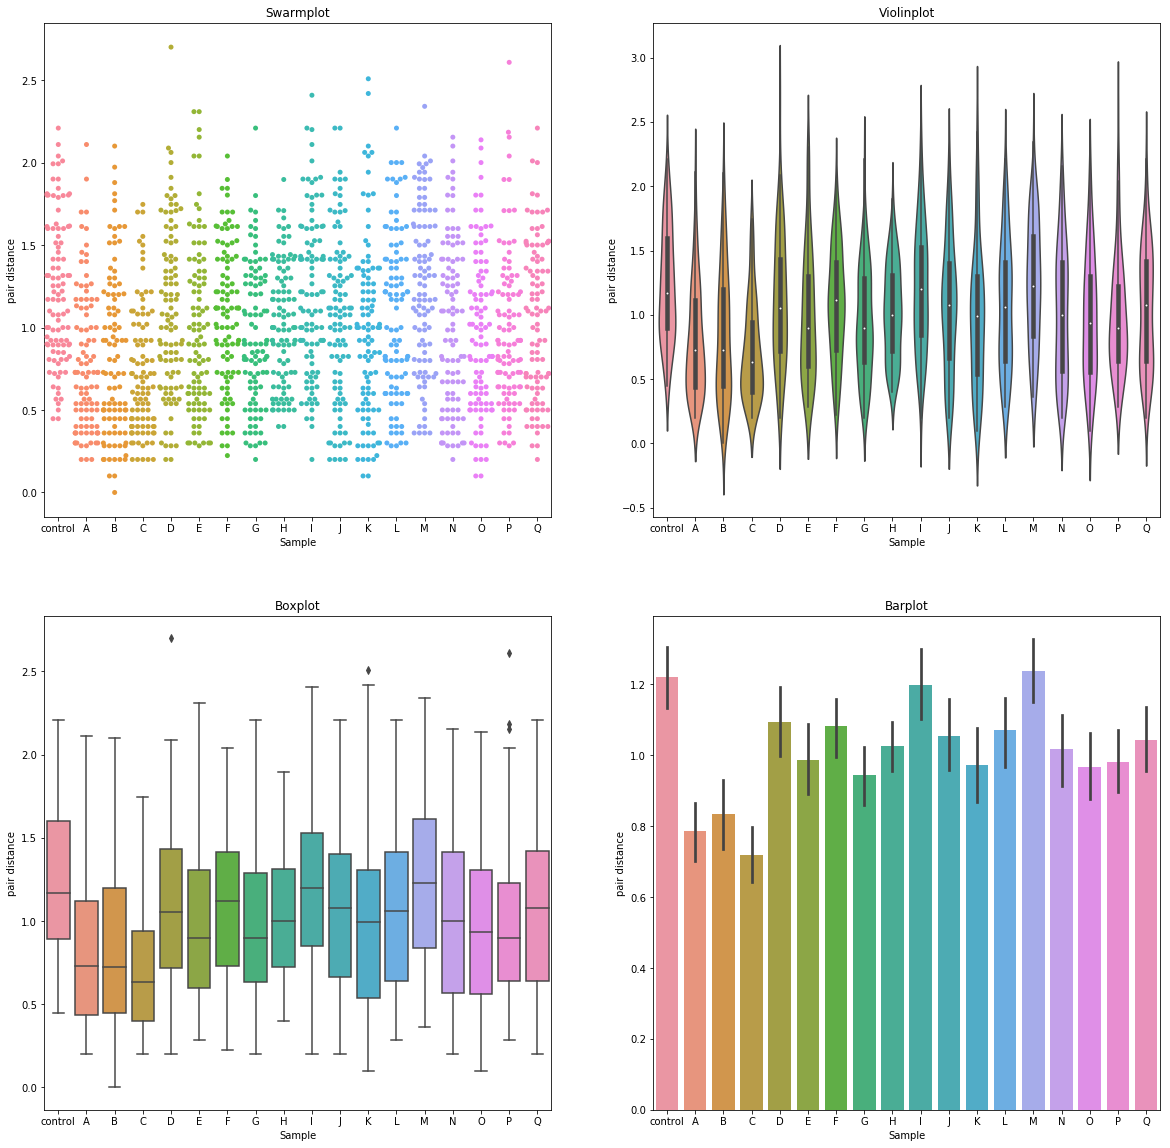

In [14]:
# Set up the matplotlib figure
#ax.boxplot(x="Sample",y="pair distance",data=data_df)
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(20,20))
sns.swarmplot(ax=ax[0][0],x="Sample",y="pair distance",data=data_df).set_title("Swarmplot")
sns.violinplot(ax=ax[0][1],x="Sample",y="pair distance",data=data_df).set_title("Violinplot")
sns.boxplot(ax=ax[1][0],x="Sample",y="pair distance",data=data_df).set_title("Boxplot")
sns.barplot(ax=ax[1][1],x="Sample",y="pair distance",data=data_df).set_title("Barplot")

# Problem 1b: Fitting distributions

Some of the samples appear to produce a Gaussian distribution, while others seem to be the result of two Gaussians. Which distribution is more likely for each dataset? We need to do the following:

1. Calculate the mean and standard deviation.
2. Use these parameters to produce a Gaussian distribution with the data.
3. Use this function to define the log-likelihood of this function.
4. Use the maximum likeklihood function to calculate the best parameters for a double-Gaussian.
5. Use these parameters to define the log-likelihood for each sample.
6. Use these log-likelihoods in the Bayesian Information Criterion to decide which distribution is most likely.

I normally like to work in the realm of arrays, rather than DataFrames. This is because I like to leverage the power and speed of executing linear algebra functions instead of FOR loops. These functions are pre-compiled, so they are much faster. Iteratively going through arrays or DataFrames is computationally exhaustive, and take a long time to run when using large arrays of data.

So, first I make a numpy array where the rows are observations, and columns are samples.

In [15]:
#convert dataframe to numpy array
data_n = data_df.to_numpy()
data_n = pd.to_numeric(data_n[:,0])
data_n.resize(18,100)
data_n = np.transpose(data_n)


Gaussian Distribution:

Next, I can compute the mean and standard deviation for every sample with one command, by setting the axis = 0.

In [16]:
mu = np.nanmean(data_n, axis = 0)
sigma = np.nanstd(data_n, axis = 0)

Isn't that great? I avoided a FOR loop by using an array, and telling the function which axis to use. Both mu and sigma have 18 entries, because I calculated the mean for each column (down the rows, or axis = 0). If I had chosen axis=1, mu and sigma would be 100 elements long, because I would have calculated the mean and standard deviation of each row.

Next, I create a function that creates the Gaussian distribution, and also the log-likelihood for a Gaussian.

In [17]:
def gauss_fun(x,mu,sigma):
    # x is a matrix, mu and sigma are vectors
    
    amp = np.power(2*np.pi*np.power(sigma,2),0.5)
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.))) / amp


# Gaussian logL
    
def gausslogl(x, mu, sigma):
    # x is a matrix, mu and sigma are vectors
    
    p = gauss_fun(x,mu,sigma)
    return np.nansum(np.log(p), axis = 0)


# Log-likelihood of each sample

logL1 = gausslogl(data_n, mu, sigma)


Since Gaussian distributions are so common in scientific work, the scipy library has a norm function that can perform all sorts of useful operations, including the above calculations. You can compare the results below and see that the code above matches what you would get from these functions. However, scipy doesn't have all the distributions possible in the world, so knowing how to code this for yourself is useful.

Double-Gaussian log-likelihood:

The double Gaussian log-likelihood function is simply the log of the sum of two Gaussians.

NOTE: I output the NEGATIVE of a log-likelihood with this function. Why I do this is explained below.


In [18]:
# Double Gaussian log likelihood function

def dgausslogl(params,x):
    
    mu1 = params[0]
    mu2 = params[1]
    sigma1 = params[2]
    sigma2 = params[3]
    w = params[4]
    
    gauss1 = gauss_fun(x,mu1,sigma1)
    gauss2 = gauss_fun(x,mu2,sigma2)
    
    p = w*gauss1 + (1-w)*gauss2
    
    return -np.nansum(np.log(p))


Next up is using the log likelihood function for the double Gaussian to identify the best parameters to use for each sample. To do this, we will use a non-linear optimizer from scipy called "minimize". It is a recursive algorithm that takes as input a function and parameters, and changes the parameters until the function reaches a minimum. The input function we will use is the double Gaussian log-likelihood function which is simply the log of the sum of two Gaussians.

A KEY point here is that we want to MAXIMIZE the likelihood function, but we are using a MINIMIZE function, so the function below returns the NEGATIVE of the log-likelihood so that the minimum of this is actually the maximum for the log likelihood function.

After I use the maximize the negative of the log-likelihood function to find the best parameters of a double Gaussian for each sample, I then save the log-likelihood of the double Gaussian for each sample.


In [19]:
logL2 = np.zeros(np.shape(logL1))

params_double = np.zeros((5,18))

for m in (range(len(mu))):
    params0 = [mu[m] - sigma[m], mu[m] + sigma[m], sigma[m], sigma[m], 0.6]
    result = minimize(dgausslogl, params0, args=data_n[:,m], method='Nelder-Mead')
    params_double[:,m] = result.x
    logL2[m] = -dgausslogl(result.x,data_n[:,m])


Now that we've calculated the log likelihood functions for both the single and double Gaussian distributions, we're ready to calculate the BIC! Remember, the model that produces the LOWEST BIC is the one that is most likely, RELATIVE to the other models it is compared to.

In the cell below, use the BIC function from Lecture 1 to calculate which distribution is most likely for each sample.

# Student Input Cell

In [4]:
# BIC: Best model has LOWEST BIC



# Problem 2: Solving ODE functions

We’re going to analyze a simple compartment model used in epidemiology, the SIR (Susceptible, Infected, Recovered) model. It is a set of couple ordinary differential equations (ODEs) that describe the spread of an infectious disease through a population. This forms the basis for many other, more complicated models you may have seen discussed in the news. In many ways, it is very similar to the types of equations used to model chemical dynamics. For example, to create a new infected person, an infected person must come into contact with a susceptible person, therefore the kinetic term is the product of these two popualtions, just like an enzyme coming into contact with its substrate. 

Below is a flow diagram for disease progression:

 

The ordinary differential equations (ODEs) are:

dS/dt= -βSI

dI/dt= βSI- γI

dR/dt=(1-f)γI

dD/dt=fγI


Where:

S = Susceptible population

I = Infected population

R = Recovered population

β = disease transmission rate

γ = recovery rate

f = fraction of infected that die

<div>
<img src="SIR1.png" width="500"/>
</div>

ODE Solver you will need:

In [18]:
from scipy.integrate import solve_ivp


The SIR function:

In [19]:
# SIR ODE, returns the following:
#
# dS/dt
# dI/dt
# dR/dt
# dD/dt

def SIR(t,y):
    return np.array([-beta*y[0]*y[1], beta*y[0]*y[1] - gamma*y[1], (1-f)*gamma*y[1],
             f*gamma*y[1]])

For this problem, we are going to model the progression of COVID in NYC, using parameters and population numbers gathered from public data during the time when the shelter in place order was put in place. For these calculations, to make things a little easier, we are normalizing all population numbers by the total population of NYC. When COVID first spread through the city, it grew with exponential growth, because:

dI/dt= βSI

At day t=0, there were 30 confirmed COVID cases. By day 12, there were 17,644 confirmed cases in the city. At this point, the city instituted a lockdown order, with the hopes of ebbing the spread of the disease. By day 52, the number of confirmed cases had risen to 167,000. The question here is did the lockdown order have an effect? What would the numbers had been like without any intervention?

Below are the parameters for the model based on observed rates of transmission and city statistics:


In [20]:
# Set Variables
# NOTE: Timescale is days

S0 = 1 # Actual NYC population: 8*np.power(10,6)
I0 = 30 / (8*np.power(10,6))

R0 = 2.2
gamma = 0.44
beta = R0*gamma/S0

# Current NYC Stats

Conf = 167000 #52 days from t0
Dead = 13000 #52 days from t0
Rec = 40000 #52 days from t0

# Shelter in Place occurred t = 12 days
# Confirmed cases was ~17644 at this point

f = Dead/Conf

As I mentioned in lecture, linear systems of ODEs, where you can describe the system in matrix format, have analytical solutions, so you can calculate the time dependent states as functions of time, i.e. you can calculate S(t), I(t), R(t) & D(t) based on knowing dS/dt, dI/dt, etc.

The challenge is that you often want to know the time-dependent versions of states, but rates are often easier to observe. This is not only true in epidemiology, but also in chemistry and physics. It's often easier to calculate rates.

Unfortunately, many (most) ODE models that describe the real world are not linear, so you have to solve them numerically. One useful tool for analyzing them is using a quiver plot, where you plot the velocities, or "flows" of each variable under different conditions. Here is a diagram of a flow diagram:


<div>
<img src="quiver2.png" width="500"/>
</div>

<div>
<img src="quiver.png" width="500"/>
</div>



You can plot this by first defining a span of variables you want to analyze.

In [21]:
# PHASE PLANE

Sspan = np.linspace(0,S0,10)
Ispan = np.linspace(0,S0,10)

Next, you make a meshgrid for these, which basically creates a matrix of coordinates that you are going to peg values to.

In [22]:
# Grid of x & y values
S, I = np.meshgrid(Sspan, Ispan)


Next, for each of these coordinates, you want to calculate the rates/velocities for each variable at each point in the meshgrid.


In [23]:
# Empty matrices to fill in with velocity data
dS = np.zeros(np.shape(S))
dI = np.zeros(np.shape(I))

# Fill velocities into grid.
for m in range(S.shape[0]):
    for n in range(I.shape[0]):
        dS[m,n] = -beta*S[m,n]*I[m,n]
        dI[m,n] = beta*S[m,n]*I[m,n] - gamma*I[m,n]

It is also useful to plot the nullclines, which are paths in state space where velocities are zero. You can calculate these by setting the above ODEs to zero, and solving for the variables.

In [24]:
# Null Clines

Sn = gamma/beta
In = 0

The beta term is a rate constant that captures the probability of an infected person infecting a susceptible person. Masks decrease this rate of transmission, i.e. they decrease beta.

In the cell below, I give some example code for how to plot a flow diagram using the "quiver" function from matplotlib. Copy and paste the code above that creates the grid of velocities, and plot flow diagrams with beta values that are 0.5 * beta, 0.25 * beta, and 0.1 * beta. Make sure to plot the null cline as well. How does the flow change?

# Student Input Cell

Text(0, 0.5, 'I')

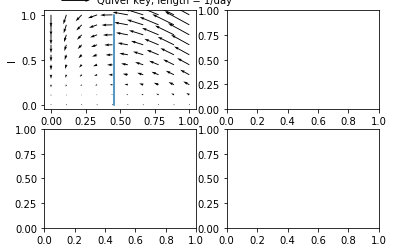

In [25]:
# Copy and past the velocities grid and null cline code here, and use it to write a for loop of different
# beta values you will use to create different flows that you will plot with the quiver function.

fig, ax = plt.subplots(2,2)
q = ax[0,0].quiver(S , I , dS, dI)

# Flow diagram
ax[0,0].quiverkey(q, X=0.3, Y=1.1, U=1,label='Quiver key, length = 1/day', labelpos='E')

# Null Cline
ax[0,0].plot([Sn, Sn], [0,S0])
ax[0,0].set_xlabel('S')
ax[0,0].set_ylabel('I')

The flow diagrams are great because they give you a feel for how the variables will flow in time, but often you want to predict what their values will actually be over time, i.e. we want to know I(t), not dI/dt. To do this, we'll use one of scipy's (many) ODE solvers. The basis for this solver is Euler's Method discussed in class.

I provide some example code below for how to use the ODE solver. The example I give is starting with the initial conditions from above on day t=0, and then predicting the progression of the disease after 52 days.

What I want you to do:

I want you to predict what would happen if you intervened on day t=12 with the shelter in place order. Assume this decreases the number of susceptible people (S) by 42%. How does the disease progress after this? Plot the S, I, D, & R over time for both no-intervention, and with intervention. Also plot the cumulative populations for each.

# Student Input Cell

In [5]:
# Without Intervention
sol_no_int = solve_ivp(SIR, [0,51],[S0,I0,0,0],max_step = 1)



# Problem 3: PCA & tSNE

For this problem, you will simply be plotting a dataset of three clusters with PCA and tSNE.

Functions you will need:

In [30]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
#-----------#
# EMBEDDING #
#-----------#

# Raw Data

data = np.loadtxt('Embed_input.txt',delimiter='\t')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:1000,0], data[:1000,1], data[:1000,2])
ax.scatter(data[1000:2000,0], data[1000:2000,1], data[1000:2000,2])
ax.scatter(data[2000:,0], data[2000:,1], data[2000:,2])
plt.title('Raw Data')

# PCA

pca = PCA(n_components=2)
pca.fit(data)
pca_embedded = pca.transform(data)

fig = plt.figure()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA Embedding')


sns.scatterplot(x=pca_embedded[:1000, 0], y=pca_embedded[:1000, 1])
sns.scatterplot(x=pca_embedded[1000:2000, 0], y=pca_embedded[1000:2000, 1])
sns.scatterplot(x=pca_embedded[2000:, 0], y=pca_embedded[2000:, 1])

As you can see from the plots, the three clusters are distinct, but not spherical. PCA has a tough time with them. In the code below, I use tSNE with perplexity set to 30.

Modify the code to show what the embedding looks like when you set the perplexity to 2, 30, 50, or 100.

NOTE: The tSNE function takes some time to run. Depending on your processor speed, it might take a couple of minutes.


# Student Input Cell

In [ ]:
# TSNE

f, axes = plt.subplots(2, 2)
f.suptitle('tSNE')

tsne_embedded = TSNE(n_components=2,perplexity=30).fit_transform(data)
sns.scatterplot(x=tsne_embedded[:1000, 0], y=tsne_embedded[:1000, 1],ax = axes[0,0])
sns.scatterplot(x=tsne_embedded[1000:2000, 0], y=tsne_embedded[1000:2000, 1],ax = axes[0,0])
sns.scatterplot(x=tsne_embedded[2000:, 0], y=tsne_embedded[2000:, 1],ax = axes[0,0])
    